In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras_core import callbacks
from keras import ops
from keras import layers
from keras import optimizers
import keras_tuner
from tensorflow_probability import distributions as tfd
from scipy.stats import linregress
from molmass import Formula

from support import *


Using TensorFlow backend





#### Data pre-process and visualization

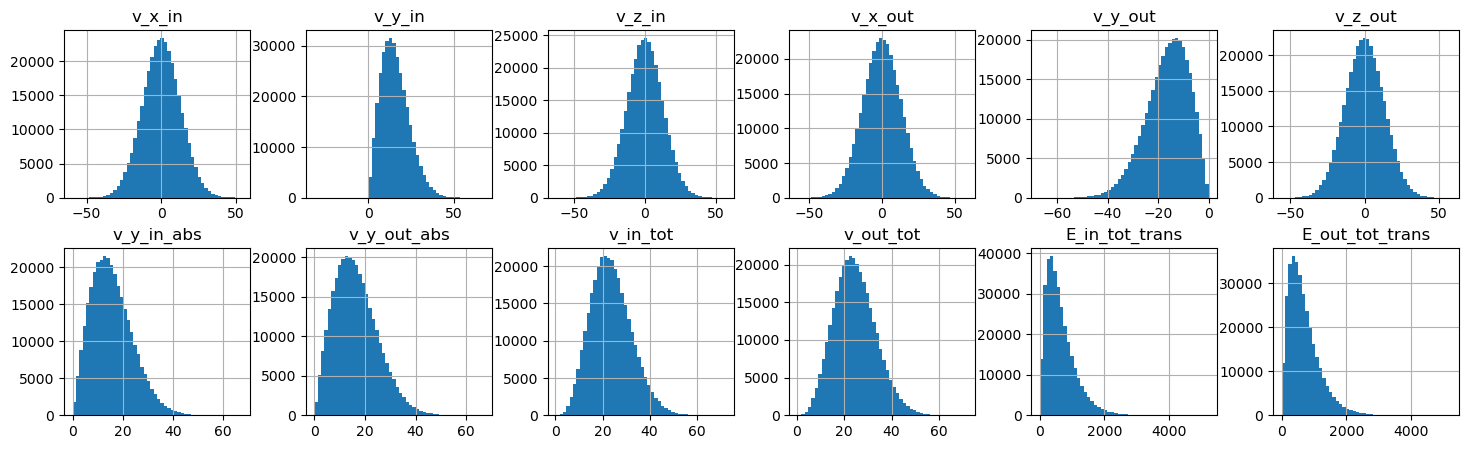

In [3]:
filename = r'D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\H2_NonIsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_T500_Tb_300.txt'

names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)

names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)

# Get molecular mass of H2
MASS_H2 = Formula('H2').mass 

# Creating columns for overall velocities
df_trans_vel['v_y_in_abs'] = np.absolute(df_trans_vel["v_y_in"])
df_trans_vel['v_y_out_abs'] = np.absolute(df_trans_vel["v_y_out"])
df_trans_vel['v_in_tot'] = (np.power(df_trans_vel["v_x_in"],2)+ np.power(df_trans_vel["v_y_in"],2) + np.power(df_trans_vel["v_z_in"],2))**0.5
df_trans_vel['v_out_tot'] = (np.power(df_trans_vel["v_x_out"],2)+ np.power(df_trans_vel["v_y_out"],2) + np.power(df_trans_vel["v_z_out"],2))**0.5
df_trans_vel['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_trans_vel["v_x_in"],2)+ np.power(df_trans_vel["v_y_in"],2) + np.power(df_trans_vel["v_z_in"],2)))
df_trans_vel['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_trans_vel["v_x_out"],2)+ np.power(df_trans_vel["v_y_out"],2) + np.power(df_trans_vel["v_z_out"],2)))

# Plot the data
df_trans_vel.hist(bins = 50, layout= (2,6), figsize= (18,5))

x = df_trans_vel.loc[:, ].values

# Normalization
scaler = MinMaxScaler()
min_max_values = scaler.fit(x)
x_norm = scaler.fit_transform(x) 

# Create dataframe with normalized values
names_trans_vel_norm = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out', 'v_y_in_abs', 'v_y_out_abs', 'v_in_tot','v_out_tot', 'E_in_tot_trans', 'E_out_tot_trans']
df_trans_vel_norm = pd.DataFrame(x_norm,columns=names_trans_vel_norm)

# Convert dataframe to numpy arrays
x = df_trans_vel_norm[['v_x_in', 'v_y_in', 'v_z_in']].to_numpy()
y = df_trans_vel_norm[['v_x_out', 'v_y_out', 'v_z_out']].to_numpy()
x_1 = df_trans_vel_norm[['v_x_in']].to_numpy()
y_1 = df_trans_vel_norm[['v_x_out']].to_numpy()
x_2 = df_trans_vel_norm[[ 'v_y_in']].to_numpy()
y_2 = df_trans_vel_norm[[ 'v_y_out']].to_numpy()

## Visualization 

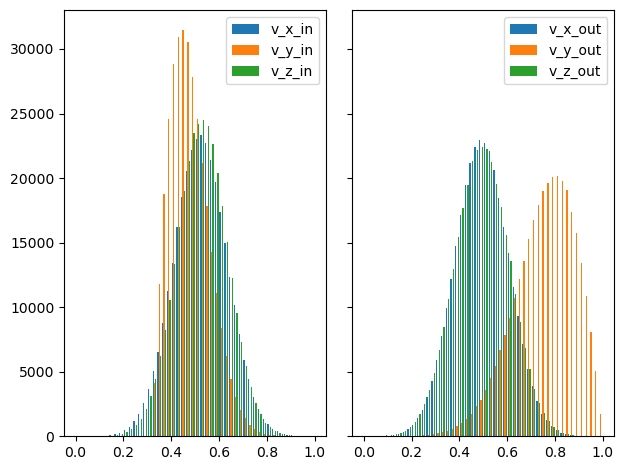

In [4]:
n_bins = 50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(x, bins=n_bins, label = ['v_x_in','v_y_in','v_z_in'])
axs[1].hist(y, bins=n_bins, label = ['v_x_out','v_y_out','v_z_out'])
axs[0].legend()
axs[1].legend()
plt.show()

d:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\support.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\HP\anaconda3\envs\experiments\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


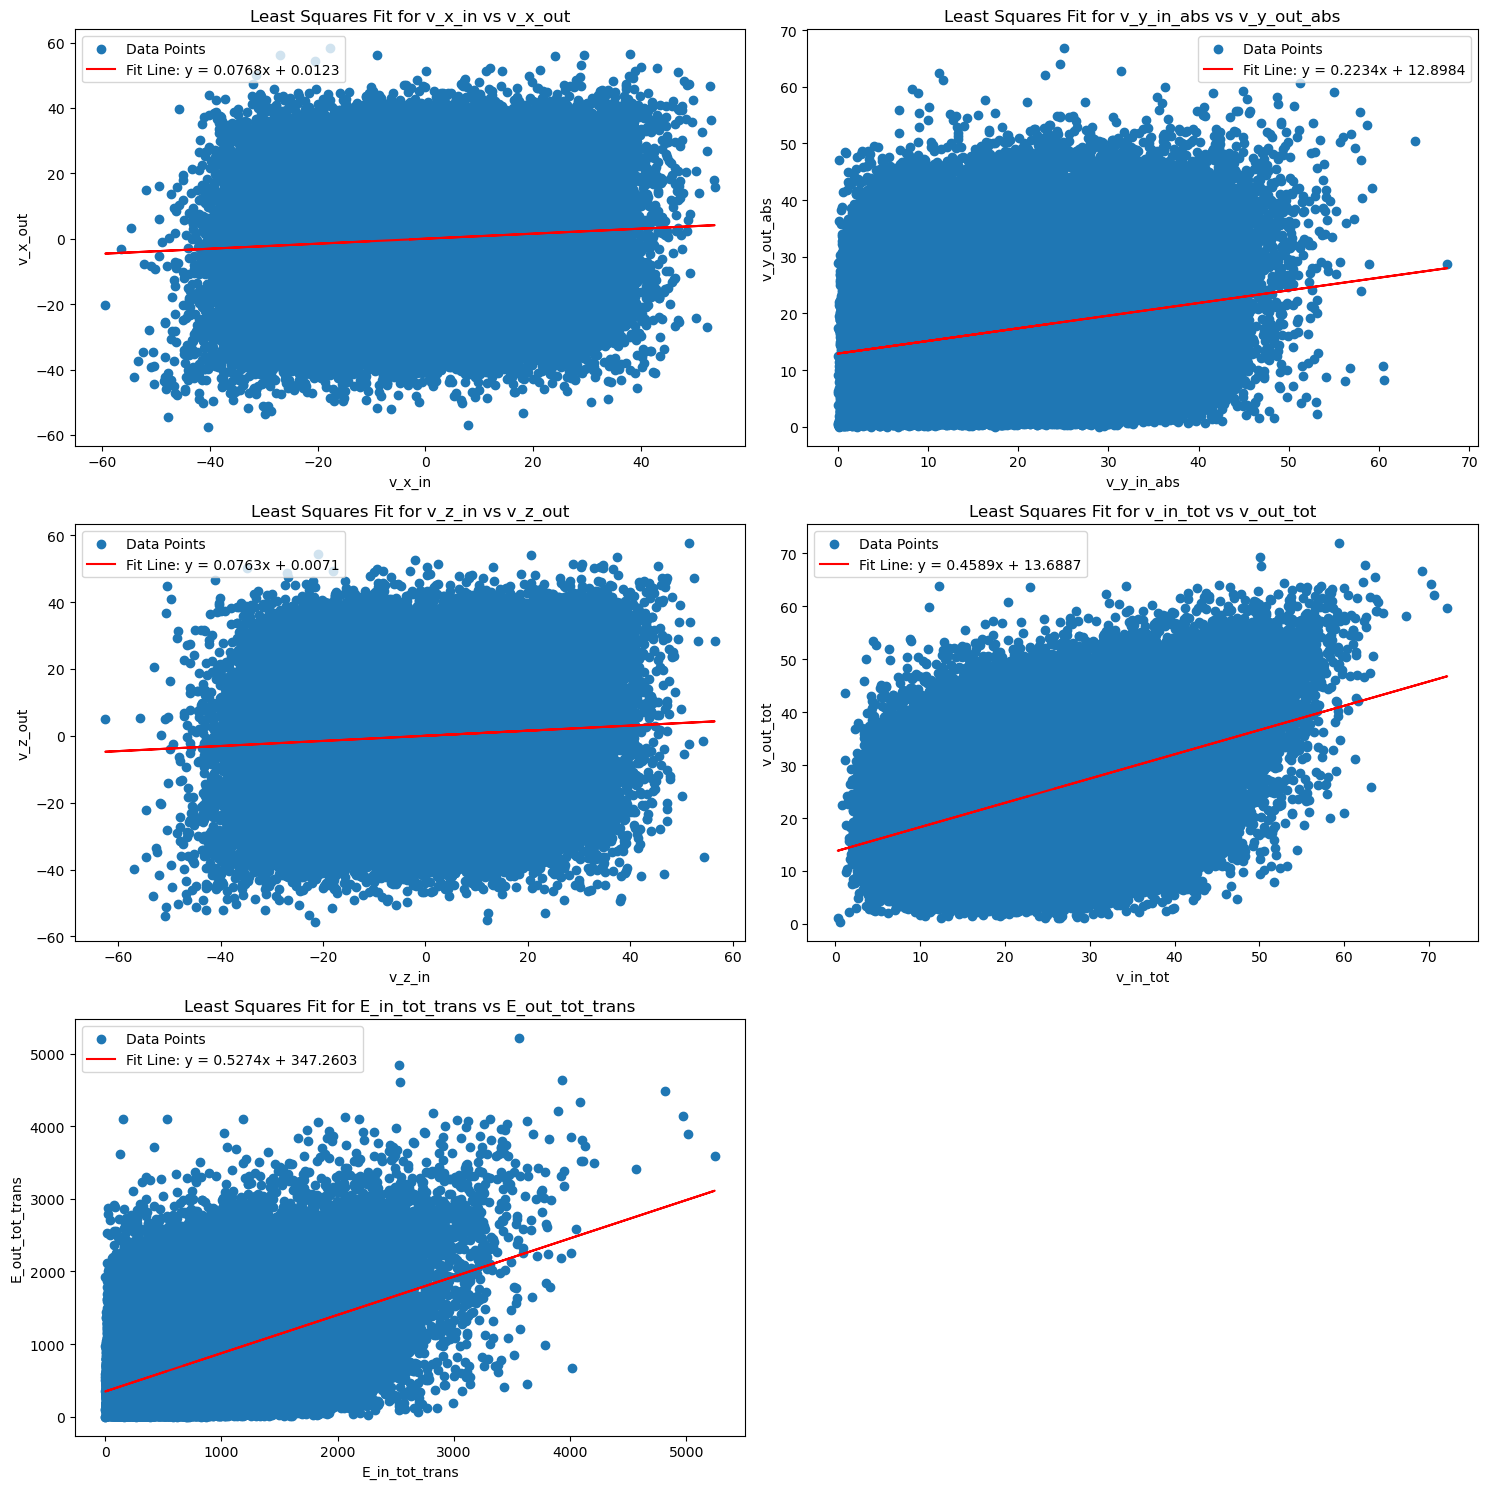

Slope, Intercept and AC for v_x_in vs v_x_out: Slope = 0.07677102118837258, Intercept = 0.012251896559738561, AC = 0.9232289788116275
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs: Slope = 0.22336121080485882, Intercept = 12.898408288495112, AC = 0.7766387891951412
Slope, Intercept and AC for v_z_in vs v_z_out: Slope = 0.07631123400357001, Intercept = 0.007063128666506132, AC = 0.92368876599643
Slope, Intercept and AC for v_in_tot vs v_out_tot: Slope = 0.45890137478264315, Intercept = 13.68865684864843, AC = 0.5410986252173569
Slope, Intercept and AC for E_in_tot_trans vs E_out_tot_trans: Slope = 0.5274207366450596, Intercept = 347.26029180513575, AC = 0.4725792633549404


In [5]:
# List of column pairs to fit and plot
cols_pairs = [
    ('v_x_in', 'v_x_out'), 
    ('v_y_in_abs', 'v_y_out_abs'), 
    ('v_z_in', 'v_z_out'), 
    ('v_in_tot', 'v_out_tot'),
    ('E_in_tot_trans', 'E_out_tot_trans')
    # Add more pairs as required
]

# Fit and plot all specified pairs
calculate_AC_scatter(df_trans_vel, cols_pairs)

#### Build and compile model

In [6]:
n_Units = 64
N_MIXES = 40
OUTPUT_DIMS = 1

lr = 0.001
loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
optimizer = optimizers.Adam(learning_rate=lr)
activation = "relu"

def model(num_Mixes, n_Units, optimizer, loss_function):
    inputs1 = keras.Input(shape=(1, 1))
    inputs2 = keras.Input(shape=(1, 1))
    inputs3 = keras.Input(shape=(1, 1))

    concat_layer = layers.concatenate([inputs1, inputs2, inputs3])
    dense_layer = layers.Dense(units=n_Units, activation="relu")(concat_layer)

    x1 = layers.Dense(units=n_Units, activation= activation)(dense_layer)
    #x1 = layers.Dense(units=n_Units, activation=activation)(x1)
    block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

    x2 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x2 = layers.Dense(units=n_Units, activation=activation)(x2)
    block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)


    x3 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x3 = layers.Dense(units=n_Units, activation=activation)(x3)
    block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

    model = keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=[block_1_output,block_2_output, block_3_output])
    model.compile(
        optimizer=optimizer,
        loss= loss_function
        )
    return model

mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

mdn_network.summary()

keras.utils.plot_model(mdn_network, show_shapes=True)

# OLD MODEL 

# n_Units = 64
# N_MIXES = 40
# OUTPUT_DIMS = 1

# lr = 0.001
# loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
# optimizer = optimizers.Adam(learning_rate=lr)

# def model(num_Mixes, n_Units, optimizer, loss_function):
#     inputs1 = keras.Input(shape=(1, 1))
#     x1 = layers.Dense(units=n_Units, activation="relu")(inputs1)
#     x1 = layers.Dense(units=n_Units, activation="relu")(x1)
#     block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

#     inputs2 = keras.Input(shape=(1, 1))
#     x2 = layers.Dense(units=n_Units, activation="relu")(inputs2)
#     x2 = layers.Dense(units=n_Units, activation="relu")(x2)
#     block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)

#     inputs3 = keras.Input(shape=(1, 1))
#     x3 = layers.Dense(units=n_Units, activation="relu")(inputs3)
#     x3 = layers.Dense(units=n_Units, activation="relu")(x3)
#     block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

#     model = keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=[block_1_output,block_2_output, block_3_output])
#     model.compile(
#         optimizer=optimizer,
#         loss= loss_function
#         )
#     return model

# mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

# mdn_network.summary()

# keras.utils.plot_model(mdn_network, show_shapes=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 64)     │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 64)     │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 64)     │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 64)     │      4,160 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 64)     │      4,160 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 120)    │      7,800 │ dense_1[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 120)    │      7,800 │ dense_3[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 120)    │      7,800 │ dense_5[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,264 (141.66 KB)

 Trainable params: 36,264 (141.66 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### Make train, test and validation split

In [7]:
# Test, train and validation split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=2)

### Training the MDN

In [8]:
# Reshaping the inputs and output tensors
x_1 = X_train[:,0].reshape((len(X_train[:]),1))
x_2 = X_train[:,1].reshape((len(X_train[:]),1))
x_3 = X_train[:,2].reshape((len(X_train[:]),1))
y_1 = y_train[:,0].reshape((len(y_train[:]),1))
y_2 = y_train[:,1].reshape((len(y_train[:]),1))
y_3 = y_train[:,2].reshape((len(y_train[:]),1))

x_1_val = X_val[:,0].reshape((len(X_val[:]),1))
x_2_val = X_val[:,1].reshape((len(X_val[:]),1))
x_3_val = X_val[:,2].reshape((len(X_val[:]),1))
y_1_val = y_val[:,0].reshape((len(y_val[:]),1))
y_2_val = y_val[:,1].reshape((len(y_val[:]),1))
y_3_val = y_val[:,2].reshape((len(y_val[:]),1))

x_1_test = X_test[:,0].reshape((len(X_test[:]),1))
x_2_test = X_test[:,1].reshape((len(X_test[:]),1))
x_3_test = X_test[:,2].reshape((len(X_test[:]),1))
y_1_test = y_test[:,0].reshape((len(y_test[:]),1))
y_2_test = y_test[:,1].reshape((len(y_test[:]),1))
y_3_test = y_test[:,2].reshape((len(y_test[:]),1))


In [9]:
# Train the model
history = mdn_network.fit(
    [x_1, x_2, x_3],
    [y_1, y_2, y_3],
    epochs=100,
    batch_size = 128,
    validation_split=0.05,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 126s 23ms/step - loss: -1.4531 - val_loss: -2.2411 - learning_rate: 0.0010
Epoch 2/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: -2.2703 - val_loss: -2.2528 - learning_rate: 0.0010
Epoch 3/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: -2.2790 - val_loss: -2.2606 - learning_rate: 0.0010
Epoch 4/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: -2.2830 - val_loss: -2.2748 - learning_rate: 0.0010
Epoch 5/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: -2.2873 - val_loss: -2.2844 - learning_rate: 0.0010
Epoch 6/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: -2.2890 - val_loss: -2.2757 - learning_rate: 0.0010
Epoch 7/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: -2.2901 - val_loss: -2.2772 - learning_rate: 0.0010
Epoch 8/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: -2.2943 - val_loss: -2.2781 - learning_rate: 0.0010
Epoch 9/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss

### Hyperparameter tuning - Defining search space and optimization

In [19]:
def model(hp, num_Mixes = 20, n_Units = 32, activation = 'relu',  dropout = False, dropout_rate = 0.2, optimizer = "", lr = 0.001):

    inputs1 = keras.Input(shape=(1, 1))
    inputs2 = keras.Input(shape=(1, 1))
    inputs3 = keras.Input(shape=(1, 1))

    concat_layer = layers.concatenate([inputs1, inputs2, inputs3])
    dense_layer = layers.Dense(units=n_Units, activation=activation)(concat_layer)

    x1 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x1 = layers.Dense(units=n_Units, activation=activation)(x1)
    block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

    x2 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x2 = layers.Dense(units=n_Units, activation=activation)(x2)
    block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)


    x3 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x3 = layers.Dense(units=n_Units, activation=activation)(x3)
    block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

    model = keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=[block_1_output,block_2_output, block_3_output])
    
    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'AdamW':
        optimizer = optimizers.AdamW(learning_rate=lr)
    elif optimizer == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=lr)
    elif optimizer == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=lr)        
    else:
        optimizer = optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optimizer,
        loss= get_mixture_loss_func(1, num_Mixes)
        )
    return model

# Define hyper-parameter search space
def build_model(hp):

    # Choices for number of Mixtures - an important advantage of using MDN
    num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=100, step=1)
    
    # Choices for number of layers, excluding output layer
    num_Layers = hp.Int("num_layers", min_value=1, max_value=10, step=1)

    # Choices for number of layers, excluding output layer
    num_Units = hp.Int("num_layers", min_value=32, max_value=32, step=32)   

    # Choices of activation
    activation = hp.Choice("activation", ["relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
    # Choice on dropout
    # dropout = hp.Boolean("dropout", default = True)

    # Choices on dropout rate
    # dropout_rate = hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

    # Choices on learning rate
    optimizer = hp.Choice("optimizer", ["adam"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
    # Call existing model-building code with the hyperparameter values.
    mdn_network = model(
        hp, 
        num_Mixes=num_Mixes, 
        n_Units = num_Units,  
        activation=activation, 
        #num_Layers=num_Layers,
        #dropout_rate= dropout_rate, 
        #dropout=dropout,  
        optimizer = optimizer
    )
    return mdn_network


build_model(keras_tuner.HyperParameters())

# Directory to store the models during hyper-parameter tuning 
directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# Bayesion optimization 

tuner = keras_tuner.BayesianOptimization(
    hypermodel= build_model,
    max_trials= 40,
    objective = "loss",
    alpha=0.0001,
    beta=2.6,
    seed= 1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    project_name="models_4AI000",
    overwrite = True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_Mixes (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 5, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
optimizer (Choice)
{'default': 'Nadam', 'conditions': [], 'values': ['Nadam', 'Adadelta'], 'ordered': False}


In [63]:
# def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, optimizer = ""):
#     model =  keras.Sequential()
    
#     for i in range(1, num_Layers+1):
#         model.add(
#             layers.Dense(
#                 units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
#                 activation=activation)
#         )
#         if dropout:
#             model.add(layers.Dropout(dropout_rate=0.2))   
    
#     model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

#     if optimizer == 'Adam':
#         optimizer = optimizers.Adam(learning_rate=lr)
#     elif optimizer == 'AdamW':
#         optimizer = optimizers.AdamW(learning_rate=lr)
#     elif optimizer == 'Nadam':
#         optimizer = optimizers.Nadam(learning_rate=lr)
#     elif optimizer == 'Adadelta':
#         optimizer = optimizers.Adadelta(learning_rate=lr)        
#     else:
#         optimizer = optimizers.Adam(learning_rate=lr)

#     model.compile(
#         optimizer = optimizer,
#         loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
#     )
#     return model

# # Define hyper-parameter search space
# def build_model(hp):

#     # Choices for number of Mixtures - an important advantage of using MDN
#     num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=50, step=1)
    
#     # Choices for number of layers
#     num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

#     # Choices of activation
#     activation = hp.Choice("activation", ["relu", "leaky_relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
#     # Choice on dropout
#     dropout = hp.Boolean("dropout", [True, False])

#     # Choices on dropout rate
#     dropout_rate = hp.Float ("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

#     # Choices on learning rate
#     optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
#     # Call existing model-building code with the hyperparameter values.
#     mdn_network = model(
#         hp, num_Mixes=num_Mixes, 
#         num_Layers=num_Layers, 
#         activation=activation, 
#         dropout_rate= dropout_rate, 
#         dropout=dropout,  
#         optimizer = optimizer
#     )
#     return mdn_network


# build_model(keras_tuner.HyperParameters())

# # Directory to store the models during hyper-parameter tuning 
# directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# tuner = keras_tuner.BayesianOptimization(
#     hypermodel= build_model,
#     max_trials= 40,
#     objective = "loss",
#     alpha=0.0001,
#     beta=2.6,
#     seed= 1,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     max_retries_per_trial=0,
#     max_consecutive_failed_trials=3,
#     project_name="models_4AI000",
#     overwrite = True,
# )

# # tuner = keras_tuner.RandomSearch(
# #     hypermodel=build_model,
# #     objective="loss",
# #     max_trials=3,
# #     executions_per_trial=2,
# #     overwrite=True,
# #     directory= directory,
# #     project_name="4AI000",
# # )

# tuner.search_space_summary()

### Perform hyper-parameter tuning

In [20]:
epochs = 10
tuner.search([x_1, x_2, x_3], [y_1, y_2, y_3], epochs= epochs, validation_data=([x_1_val, x_2_val, x_3_val],[y_1_val, y_2_val, y_3_val]))

Trial 16 Complete [00h 02m 52s]
loss: -2.159994602203369

Best loss So Far: -2.170029640197754
Total elapsed time: 01h 11m 40s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
100               |10                |num_Mixes
1                 |5                 |num_layers
relu              |tanh              |activation
Nadam             |Nadam             |optimizer

Epoch 1/10
2467/2467 ━━━━━━━━━━━━━━━━━━━━ 195s 32ms/step - loss: 0.3402 - val_loss: -2.0578
Epoch 2/10
2467/2467 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: -2.0710 - val_loss: -2.0960
Epoch 3/10
2467/2467 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: -2.0988 - val_loss: -2.1162
Epoch 4/10
2467/2467 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - loss: -2.1154 - val_loss: -2.1206
Epoch 5/10
2467/2467 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - loss: -2.1226 - val_loss: -2.1258
Epoch 6/10
2467/2467 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: -2.1256 - val_loss: -2.1285
Epoch 7/10
2467/2467 ━━━━━━━━━━━━━━━━━━━━ 39s

: 

#### Compile model with best hyper-parameters 

In [39]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
mdn_network = build_model(best_hps[0])

print("The best hyper-parameters are")
print(best_hps[0].values)

The best hyper-parameters are
{'num_Mixes': 44, 'num_layers': 1, 'activation': 'relu', 'units_1': 32}


### Summary of best model

In [40]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()


c:\Users\HP\anaconda3\envs\experiments\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mixture_density_output          │ (None, 132)            │         4,356 │
│ (MixtureDensityOutput)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,420 (17.27 KB)

 Trainable params: 4,420 (17.27 KB)

 Non-trainable params: 0 (0.00 B)

### Training the best model

In [9]:
history = mdn_network.fit(
    [x_1, x_2, x_3],
    [y_1, y_2, y_3],
    epochs=100,
    batch_size = 128,
    validation_split=0.05,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100


ValueError: Layer 'functional_1' expected 3 input(s). Received 1 instead.

### Plot Loss

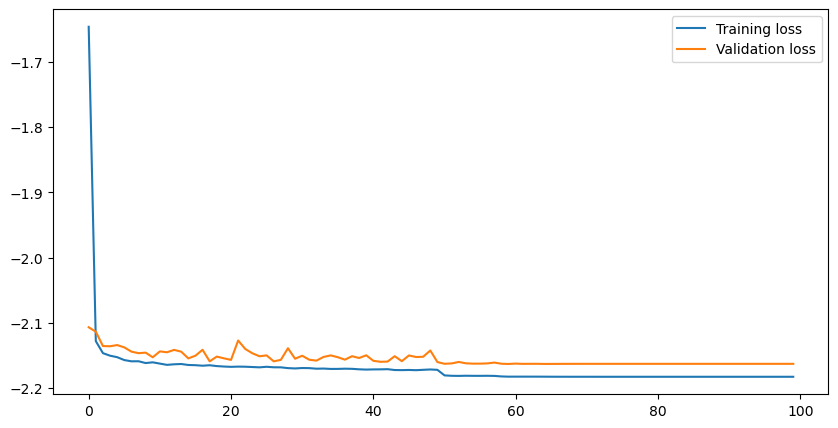

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [11]:
y_pred_mixture = mdn_network.predict((x_1_test,x_1_test, x_3_test))

771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [12]:
# Reshape and sampling
y_new = []
y_samples = []
for i in range(len(y_pred_mixture)):
    y_new.append(y_pred_mixture[i].reshape((len(y_pred_mixture[0]),N_MIXES*3)))
    y_samples.append(np.apply_along_axis(sample_from_output, 1, y_new[i], 1, N_MIXES, temp=1.0))
    y_samples[i] = y_samples[i].reshape((len(y_samples[i])))    

In [17]:
# Create data frame with results and original input/output velocities

# Normalized dataframe that contains results - df_results_norm
# Renormalized df - df_results

df_results_norm = pd.DataFrame(y_samples).transpose()
df_results_norm.rename(columns = {0:'v_x_out_pred', 1:'v_y_out_pred',2:'v_z_out_pred'}, inplace = True)
df_results_norm['v_x_in'] = x_1_test
df_results_norm['v_y_in'] = x_2_test
df_results_norm['v_z_in'] = x_3_test
df_results_norm['v_x_out'] = y_1_test
df_results_norm['v_y_out'] = y_2_test
df_results_norm['v_z_out'] = y_3_test 


df_results = pd.DataFrame([])
df_results['v_x_in'] = re_normalize(df_results_norm['v_x_in'], min_max_values.data_min_[0], min_max_values.data_max_[0])
df_results['v_y_in'] = re_normalize(df_results_norm['v_y_in'], min_max_values.data_min_[1], min_max_values.data_max_[1])
df_results['v_z_in'] = re_normalize(df_results_norm['v_z_in'], min_max_values.data_min_[2], min_max_values.data_max_[2])
df_results['v_x_out'] = re_normalize(df_results_norm['v_x_out'], min_max_values.data_min_[3], min_max_values.data_max_[3])
df_results['v_y_out'] = re_normalize(df_results_norm['v_y_out'], min_max_values.data_min_[4], min_max_values.data_max_[4])
df_results['v_z_out'] = re_normalize(df_results_norm['v_z_out'], min_max_values.data_min_[5], min_max_values.data_max_[5])
df_results['v_x_out_pred'] = re_normalize(df_results_norm['v_x_out_pred'], min_max_values.data_min_[3], min_max_values.data_max_[3])
df_results['v_y_out_pred'] = re_normalize(df_results_norm['v_y_out_pred'], min_max_values.data_min_[4], min_max_values.data_max_[4])
df_results['v_z_out_pred'] = re_normalize(df_results_norm['v_z_out_pred'], min_max_values.data_min_[5], min_max_values.data_max_[5])

# Creating columns for overall velocities
df_results_norm['v_y_in_abs'] = np.absolute(df_results_norm["v_y_in"])
df_results_norm['v_y_out_abs'] = np.absolute(df_results_norm["v_y_out"])
df_results_norm['v_in_tot'] = (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2))**0.5
df_results_norm['v_out_tot'] = (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2))**0.5
df_results_norm['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2)))
df_results_norm['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2)))

# Creating columns for overall velocities
df_results['v_y_in_abs'] = np.absolute(df_results["v_y_in"])
df_results['v_y_out_abs'] = np.absolute(df_results["v_y_out"])
df_results['v_in_tot'] = (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2))**0.5
df_results['v_out_tot'] = (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2))**0.5
df_results['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2)))
df_results['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2)))


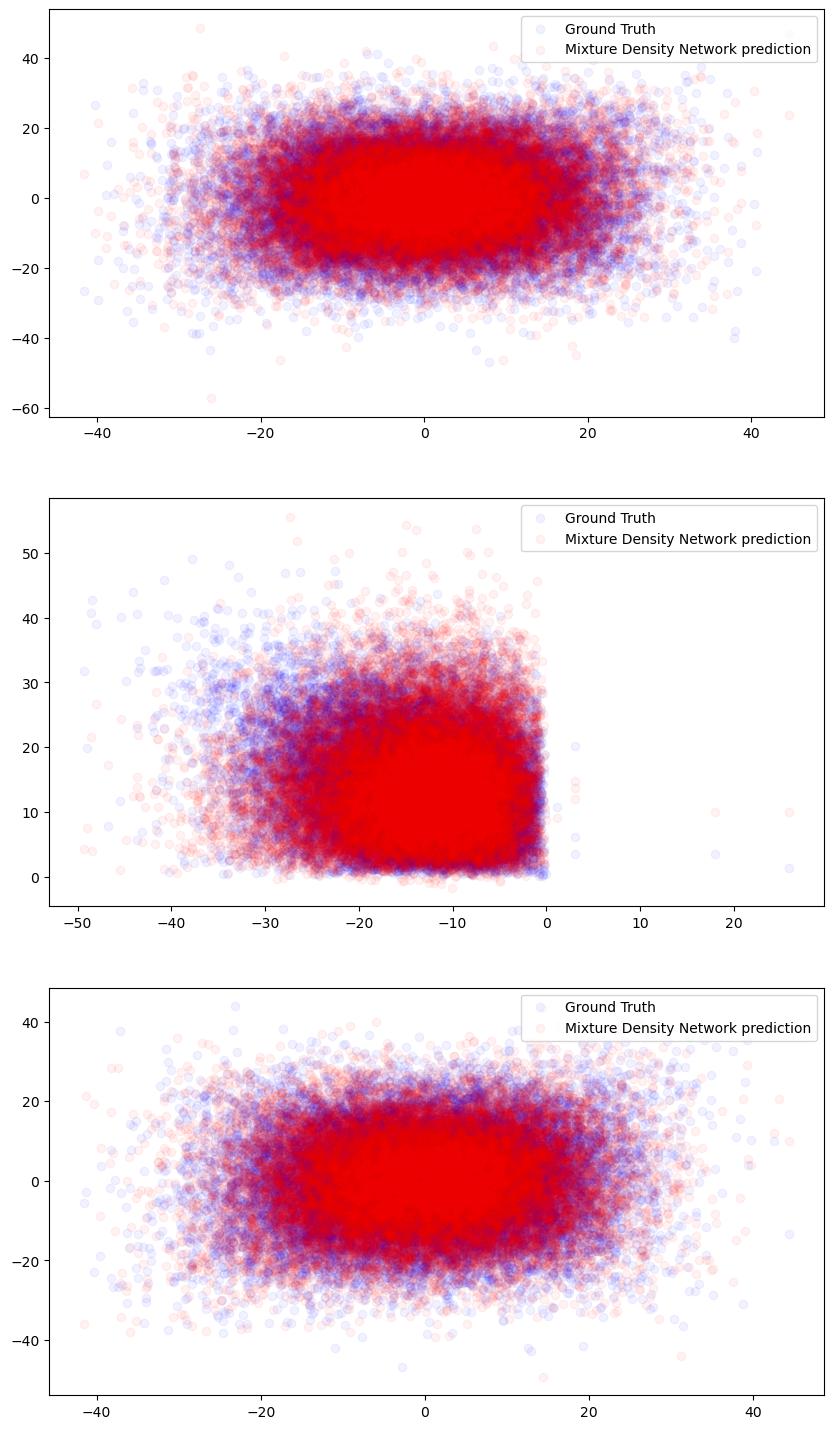

In [18]:
fig, axs = plt.subplots(3, 1, figsize = (10,18))
axs[0].scatter(df_results['v_x_in'], df_results['v_x_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[0].scatter(df_results['v_x_in'], df_results['v_x_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[0].legend(loc = 1)
axs[1].scatter(df_results['v_y_in'], df_results['v_y_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[1].scatter(df_results['v_y_in'], df_results['v_y_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[1].legend(loc = 1)
axs[2].scatter(df_results['v_z_in'], df_results['v_z_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[2].scatter(df_results['v_z_in'], df_results['v_z_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[2].legend(loc = 1)

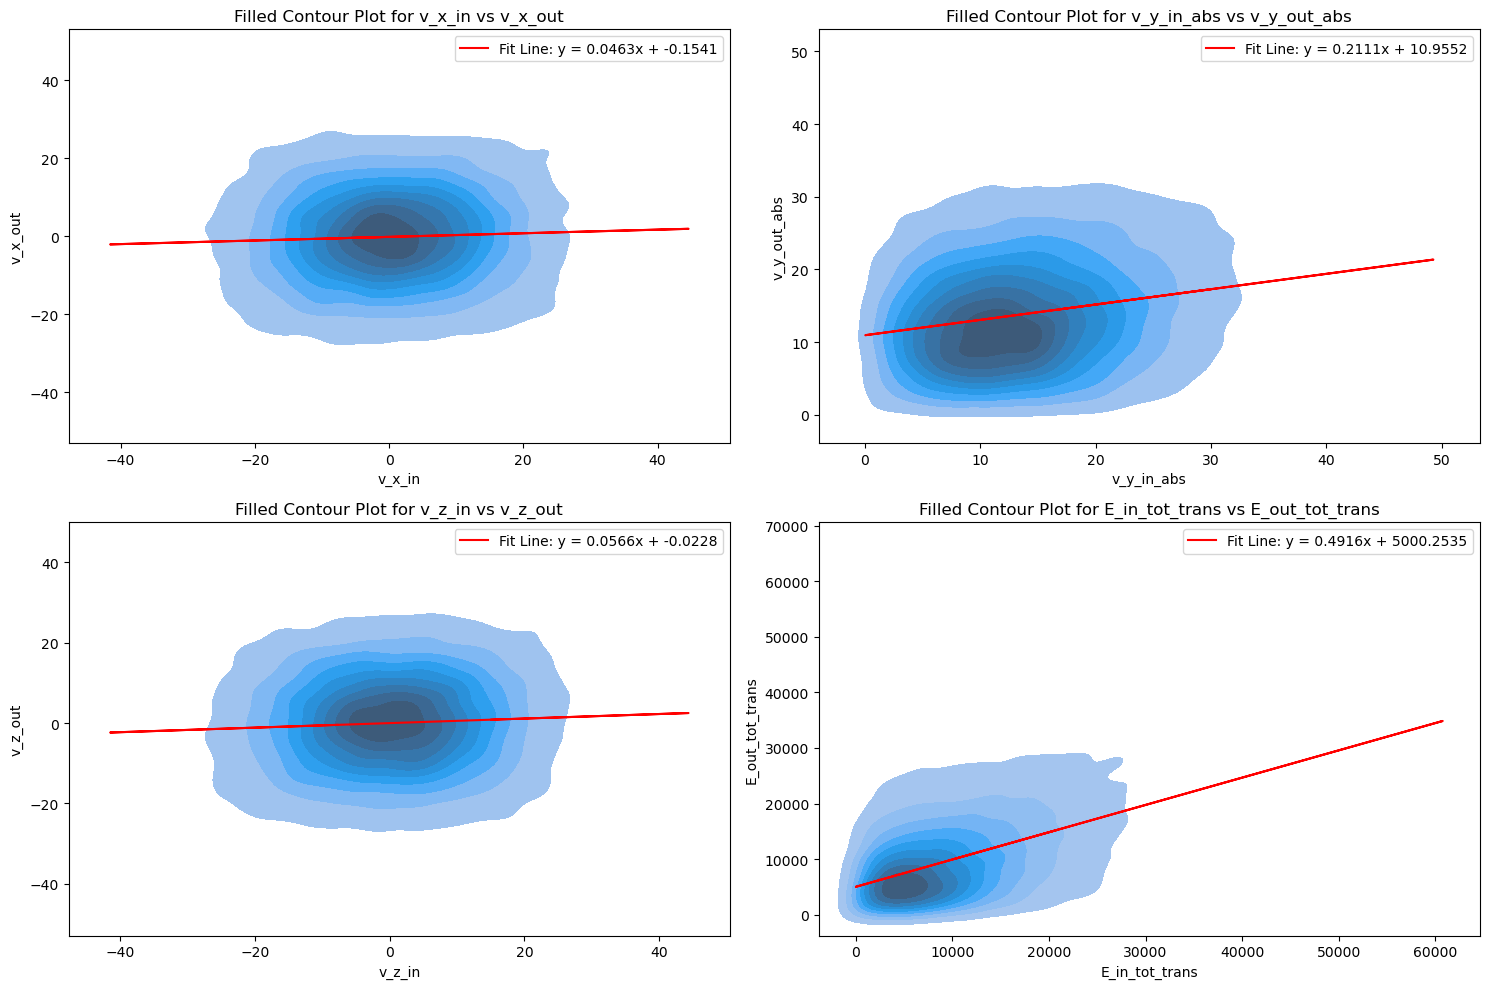

Slope, Intercept and AC for v_x_in vs v_x_out: Slope = 0.046299154048609244, Intercept = -0.15407398068380562, AC = 0.9537008459513907
Slope, Intercept and AC for v_y_in_abs vs v_y_out_abs: Slope = 0.21111422552487732, Intercept = 10.9552458000793, AC = 0.7888857744751226
Slope, Intercept and AC for v_z_in vs v_z_out: Slope = 0.05655518337440786, Intercept = -0.02278740733616591, AC = 0.9434448166255921
Slope, Intercept and AC for E_in_tot_trans vs E_out_tot_trans: Slope = 0.49155244791907804, Intercept = 5000.253541020413, AC = 0.508447552080922


In [19]:
# List of column pairs to fit and plot
cols_pairs = [
    ('v_x_in', 'v_x_out'), 
    ('v_y_in_abs', 'v_y_out_abs'), 
    ('v_z_in', 'v_z_out'), 
    ('E_in_tot_trans', 'E_out_tot_trans'), 

    # Add more pairs as required
]

# Fit and plot all specified pairs
calculate_AC_contor(df_results, cols_pairs)